In [ ]:
# !pip install torch torchvision pandas matplotlib scikit-learn seaborn tensorboard pillow fvcore
# !pip install --upgrade tensorflow tensorboard

In [ ]:
# Data Manipulation & Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os

# PyTorch & Related
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import StepLR
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.reshape_transforms import vit_reshape_transform
from tqdm import tqdm
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

# Computer Vision
from torchvision import transforms
from PIL import Image

# Evaluation Metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

2025-08-06 13:11:09.536505: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754485869.561675  387930 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754485869.569396  387930 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754485869.592255  387930 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754485869.592289  387930 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754485869.592291  387930 computation_placer.cc:177] computation placer alr

In [4]:
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

PyTorch version: 2.7.1+cu118
CUDA available: True
GPU: NVIDIA GeForce RTX 3090


In [5]:
os.chdir("C:\Hasnain")
print("Current working directory:", os.getcwd())

Current working directory: C:\Hasnain


In [3]:
# CSV Paths
train_csv_path = "datasets/FF++(HQ)/FF++(HQ)_CSV/combined_training_original_cross_data_full_with_augmentation.csv"
val_csv_path = "datasets/FF++(HQ)/FF++(HQ)_CSV/combined_validation_original_cross_data_full_with_augmentation.csv"
test_csv_path = "datasets/FF++(HQ)/FF++(HQ)_CSV/combined_testing_original_cross_data_full_with_augmentation.csv"
celebdf_path = "datasets/celebdf_v2/celeb_df_output_file.csv"
wilddeepfake_path = "datasets/wilddeepfake/wilddeepfake_test.csv"

# Hyperparameters
IMAGE_SIZE = 224
BATCH_SIZE = 32
NUM_EPOCHS = 100
NUM_WORKERS = 4
ALPHA_MIXMO = 2.0  # MixMo alpha

# Output
SAVE_PATH = "Dissertation/FFHQ/Pretrained_Best/Efficinet_Net_mixmo(alpha2)_model.pth"
LOG_DIR = "Dissertation/FFHQ/Pretrained_Best/Efficinet_Net_mixmo(alpha2)_logs"

os.makedirs(os.path.dirname(SAVE_PATH), exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)

writer = SummaryWriter(log_dir=LOG_DIR)

In [4]:
# Standard ImageNet Normalization (for pretrained models)
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

In [5]:
class DeepfakeDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.df = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_path = self.df.iloc[index]['path']
        label = int(self.df.iloc[index]['label'])
        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            image = Image.new('RGB', (IMAGE_SIZE, IMAGE_SIZE))

        if self.transform:
            image = self.transform(image)

        return image, label

In [6]:
train_loader = DataLoader(DeepfakeDataset(train_csv_path, transform), batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(DeepfakeDataset(val_csv_path, transform), batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(DeepfakeDataset(test_csv_path, transform), batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
celebdf_loader = DataLoader(DeepfakeDataset(celebdf_path, transform), batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
wilddeepfake_loader = DataLoader(DeepfakeDataset(wilddeepfake_path, transform), batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# MixMo

In [7]:
def mixmo_data(x, y, alpha=ALPHA_MIXMO):
    lam = np.random.beta(alpha, alpha)
    index = torch.randperm(x.size(0)).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixmo_loss(outputs, targets_a, targets_b, lam):
    return lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)

In [8]:
def train_one_epoch_mixmo(model, dataloader, optimizer, criterion, device, alpha=ALPHA_MIXMO):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(dataloader, desc="Training (MixMo)"):
        images, labels = images.to(device), labels.to(device)
        mixed, y_a, y_b, lam = mixmo_data(images, labels, alpha=alpha)

        optimizer.zero_grad()
        outputs = model(mixed)
        loss = mixmo_loss(outputs, y_a, y_b, lam)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = outputs.max(1)
        correct += (lam * (preds == y_a).sum().item() + (1 - lam) * (preds == y_b).sum().item())
        total += labels.size(0)

    return running_loss / len(dataloader), 100 * correct / total

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return total_loss / len(dataloader), 100 * correct / total

# EfficientNet

In [9]:
# Load pre-trained EfficientNet-B0 and modify for binary classification
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained EfficientNet-B0
model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)

# Freeze feature extractor layers
for param in model.features.parameters():
    param.requires_grad = False

# Modify the classifier for binary output
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)  # binary output
model = model.to(device)

# Loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Tracking
train_losses, val_losses, val_accuracies = [], [], []
early_stop_patience = 5
early_stop_counter = 0
best_val_loss = float('inf')

In [10]:
# Print model parameter statistics
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

print("\nTrainable parameters:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.shape}")

Total parameters: 4,010,110
Trainable parameters: 2,562

Trainable parameters:
classifier.1.weight: torch.Size([2, 1280])
classifier.1.bias: torch.Size([2])


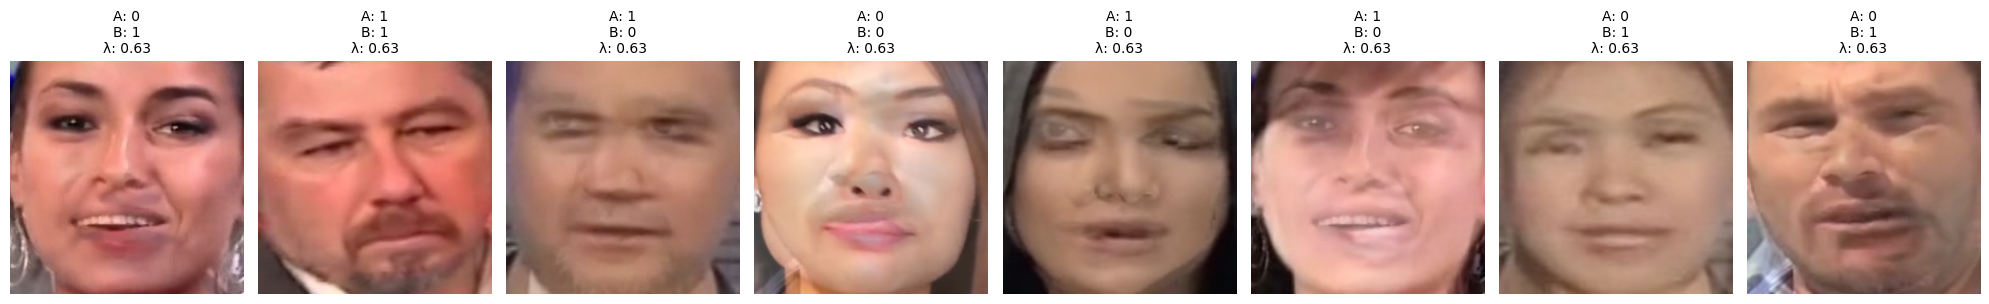

In [11]:
def denormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406], device=img_tensor.device).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], device=img_tensor.device).view(3, 1, 1)
    return img_tensor * std + mean

def show_mixmo(images, labels_a, labels_b, lam, n=8):
    images = images[:n].cpu()
    labels_a = labels_a[:n].cpu()
    labels_b = labels_b[:n].cpu()
    plt.figure(figsize=(20, 5))
    for i in range(n):
        img = denormalize(images[i]).permute(1, 2, 0).numpy()
        plt.subplot(1, n, i + 1)
        plt.imshow(np.clip(img, 0, 1))
        plt.title(f"A: {labels_a[i]}\nB: {labels_b[i]}\nλ: {lam:.2f}", fontsize=10)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Preview MixMo samples
images, labels = next(iter(train_loader))
images, labels = images.to(device), labels.to(device)
mixed_images, y_a, y_b, lam = mixmo_data(images, labels, alpha=ALPHA_MIXMO)
show_mixmo(mixed_images, y_a, y_b, lam)

In [15]:
best_val_loss = float('inf')
early_stop_counter = 0
early_stop_patience = 5

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in range(NUM_EPOCHS):
    print(f"\n Epoch {epoch + 1}/{NUM_EPOCHS}")
    
    train_loss, train_acc = train_one_epoch_mixmo(model, train_loader, optimizer, criterion, device, alpha=ALPHA_MIXMO)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    writer.add_scalar("Loss/Train", train_loss, epoch)
    writer.add_scalar("Accuracy/Train", train_acc, epoch)
    writer.add_scalar("Loss/Val", val_loss, epoch)
    writer.add_scalar("Accuracy/Val", val_acc, epoch)

    print(f" Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%")
    print(f" Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), SAVE_PATH)
        print(f" Saved best model to {SAVE_PATH}")
    else:
        early_stop_counter += 1
        if early_stop_counter >= early_stop_patience:
            print(" Early stopping triggered.")
            break

    scheduler.step()

writer.close()


 Epoch 1/100


Validation: 100%|██████████████████████████████████████████████████████████████████| 1046/1046 [04:00<00:00,  4.35it/s]


 Train Loss: 0.5546, Acc: 73.21%
 Val Loss: 0.4050, Acc: 85.57%
 Saved best model to Dissertation/FFHQ/Pretrained_Best/Efficinet_Net_mixmo(alpha2)_model.pth

 Epoch 2/100


Validation: 100%|██████████████████████████████████████████████████████████████████| 1046/1046 [03:47<00:00,  4.61it/s]


 Train Loss: 0.5437, Acc: 73.98%
 Val Loss: 0.3950, Acc: 85.36%
 Saved best model to Dissertation/FFHQ/Pretrained_Best/Efficinet_Net_mixmo(alpha2)_model.pth

 Epoch 3/100


Validation: 100%|██████████████████████████████████████████████████████████████████| 1046/1046 [03:49<00:00,  4.56it/s]


 Train Loss: 0.5446, Acc: 73.94%
 Val Loss: 0.4027, Acc: 85.26%

 Epoch 4/100


Validation: 100%|██████████████████████████████████████████████████████████████████| 1046/1046 [03:39<00:00,  4.77it/s]


 Train Loss: 0.5437, Acc: 73.96%
 Val Loss: 0.3822, Acc: 86.62%
 Saved best model to Dissertation/FFHQ/Pretrained_Best/Efficinet_Net_mixmo(alpha2)_model.pth

 Epoch 5/100


Validation: 100%|██████████████████████████████████████████████████████████████████| 1046/1046 [03:36<00:00,  4.84it/s]


 Train Loss: 0.5455, Acc: 73.83%
 Val Loss: 0.3876, Acc: 86.41%

 Epoch 6/100


Validation: 100%|██████████████████████████████████████████████████████████████████| 1046/1046 [03:38<00:00,  4.78it/s]


 Train Loss: 0.5416, Acc: 74.10%
 Val Loss: 0.3842, Acc: 86.42%

 Epoch 7/100


Validation: 100%|██████████████████████████████████████████████████████████████████| 1046/1046 [03:35<00:00,  4.86it/s]


 Train Loss: 0.5427, Acc: 73.99%
 Val Loss: 0.3879, Acc: 85.92%

 Epoch 8/100


Validation: 100%|██████████████████████████████████████████████████████████████████| 1046/1046 [03:24<00:00,  5.10it/s]


 Train Loss: 0.5411, Acc: 74.20%
 Val Loss: 0.3949, Acc: 85.45%

 Epoch 9/100


Validation: 100%|██████████████████████████████████████████████████████████████████| 1046/1046 [03:40<00:00,  4.74it/s]

 Train Loss: 0.5421, Acc: 74.15%
 Val Loss: 0.3860, Acc: 86.33%
 Early stopping triggered.


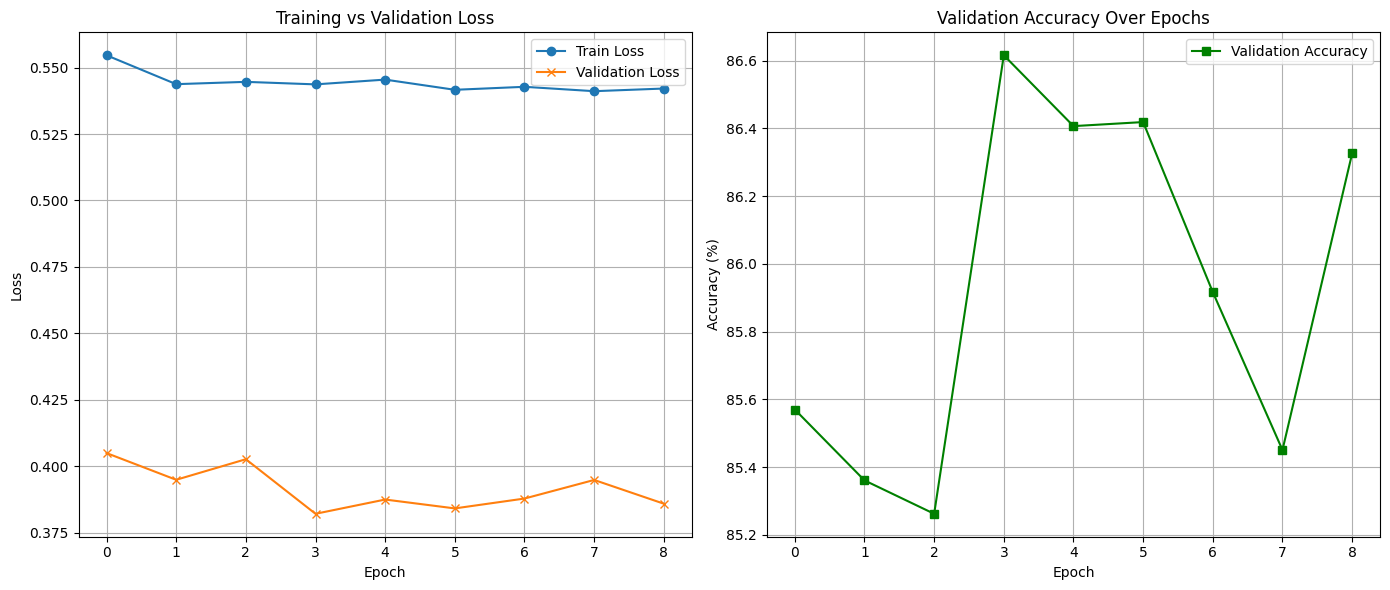

In [16]:
plt.figure(figsize=(14, 6))

# Loss Curve
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='x')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy', marker='s', color='green')
plt.title("Validation Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [12]:
def test_model_with_probs(model, dataloader, device, name):
    model.eval()
    all_probs, all_labels = [], []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc=f"{name}"):
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)[:, 1]
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.numpy())

    return np.array(all_labels), np.array(all_probs)

In [13]:
def calculate_eer(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    fnr = 1 - tpr
    abs_diffs = np.abs(fpr - fnr)
    min_index = np.argmin(abs_diffs)
    eer = (fpr[min_index] + fnr[min_index]) / 2
    threshold = thresholds[min_index]
    return eer, threshold

def plot_combined_roc_with_eer(score_label_tuples):
    plt.figure(figsize=(7, 7))
    for y_true, y_scores, label in score_label_tuples:
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        auc_score = roc_auc_score(y_true, y_scores)
        eer, _ = calculate_eer(y_true, y_scores)
        plt.plot(fpr, tpr, label=f"{label} (AUC = {auc_score:.2f}, EER = {eer:.2f})")

    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves with AUC & EER")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

In [14]:
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix", cmap="Blues"):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap,
                xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

In [15]:
# Load best model
model.load_state_dict(torch.load(SAVE_PATH))
model.to(device)

# Predict
labels_test, probs_test = test_model_with_probs(model, test_loader, device, name="FFHQ Test Set")
labels_celeb, probs_celeb = test_model_with_probs(model, celebdf_loader, device, name="CelebDF")
labels_wild, probs_wild = test_model_with_probs(model, wilddeepfake_loader, device, name="WildDeepfake")

# Thresholding
preds_test = (probs_test >= 0.5).astype(int)
preds_celeb = (probs_celeb >= 0.5).astype(int)
preds_wild = (probs_wild >= 0.5).astype(int)

WildDeepfake: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2245/2245 [01:09<00:00, 32.29it/s]


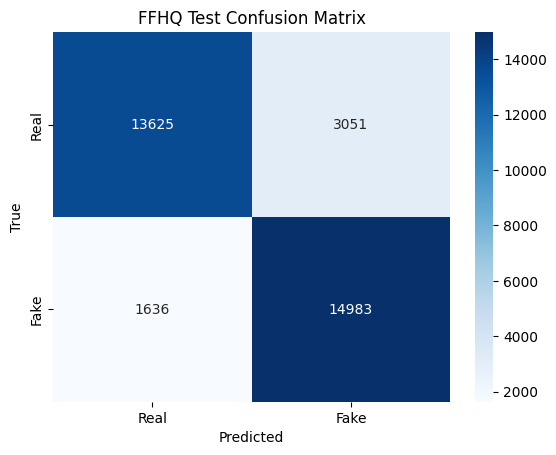

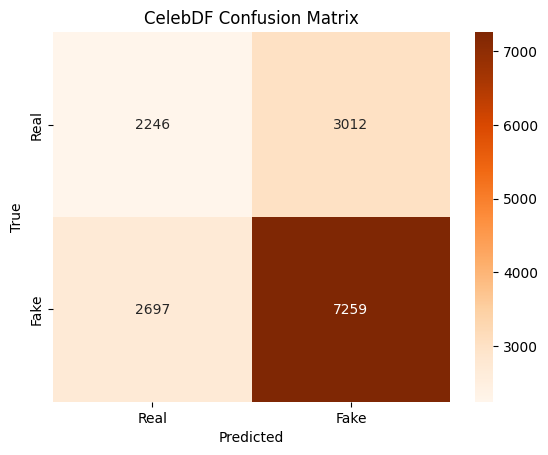

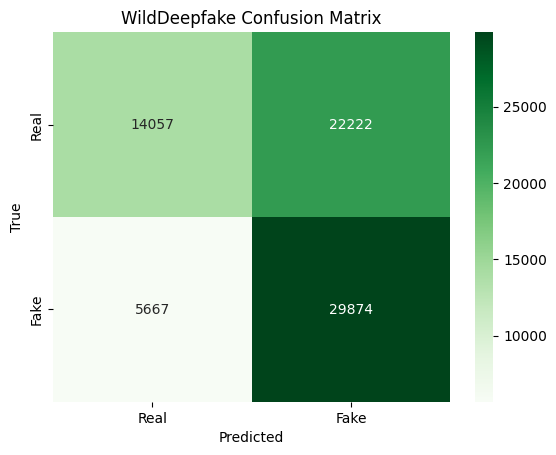

In [16]:
# Confusion Matrices
plot_confusion_matrix(labels_test, preds_test, title="FFHQ Test Confusion Matrix", cmap="Blues")
plot_confusion_matrix(labels_celeb, preds_celeb, title="CelebDF Confusion Matrix", cmap="Oranges")
plot_confusion_matrix(labels_wild, preds_wild, title="WildDeepfake Confusion Matrix", cmap="Greens")

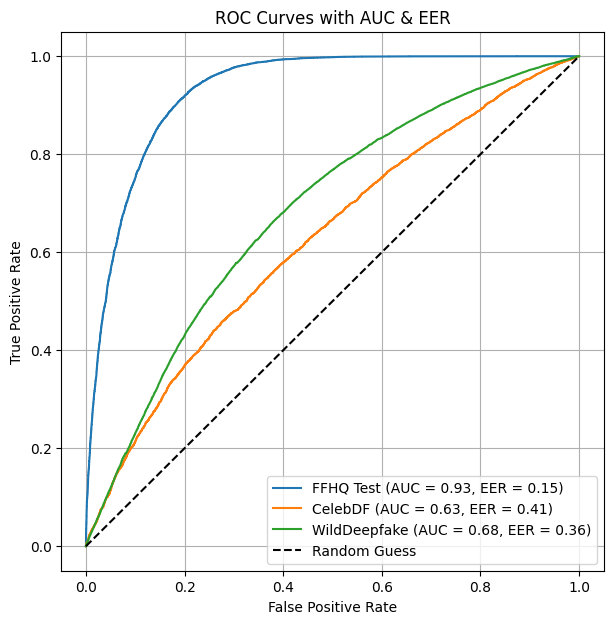

In [17]:
# ROC Curves
plot_combined_roc_with_eer([
    (labels_test, probs_test, "FFHQ Test"),
    (labels_celeb, probs_celeb, "CelebDF"),
    (labels_wild, probs_wild, "WildDeepfake")
])

In [18]:
# Classification reports

print("FFHQ Test Set Classification Report:")
print(classification_report(labels_test, preds_test, target_names=["Real", "Fake"]))

print("\nCelebDF Classification Report:")
print(classification_report(labels_celeb, preds_celeb, target_names=["Real", "Fake"]))

print("\nWildDeepfake Classification Report:")
print(classification_report(labels_wild, preds_wild, target_names=["Real", "Fake"]))

FFHQ Test Set Classification Report:
              precision    recall  f1-score   support

        Real       0.89      0.82      0.85     16676
        Fake       0.83      0.90      0.86     16619

    accuracy                           0.86     33295
   macro avg       0.86      0.86      0.86     33295
weighted avg       0.86      0.86      0.86     33295


CelebDF Classification Report:
              precision    recall  f1-score   support

        Real       0.45      0.43      0.44      5258
        Fake       0.71      0.73      0.72      9956

    accuracy                           0.62     15214
   macro avg       0.58      0.58      0.58     15214
weighted avg       0.62      0.62      0.62     15214


WildDeepfake Classification Report:
              precision    recall  f1-score   support

        Real       0.71      0.39      0.50     36279
        Fake       0.57      0.84      0.68     35541

    accuracy                           0.61     71820
   macro avg       0.6

# GradCam

In [19]:
# Step 1: Select the final Conv2d layer from the last MBConv block
target_layer = model.features[7][0].block[3][0]

# Step 2: Unfreeze it (optional, for training/fine-tuning)
for param in target_layer.parameters():
    param.requires_grad = True

# Step 3: Set up Grad-CAM
cam = GradCAM(model=model, target_layers=[target_layer])

def show_gradcam(loader, label_name="Sample", image_weight=0.5):
    model.eval()

    # Get a sample
    images, labels = next(iter(loader))
    img_tensor = images[0].unsqueeze(0).to(device)
    label = labels[0].item()

    # Get model prediction
    with torch.no_grad():
        output = model(img_tensor)
        probs = torch.softmax(output, dim=1)
        confidence, pred_label = torch.max(probs, 1)
        pred_label = pred_label.item()
        confidence = confidence.item()

    # Grad-CAM for predicted class
    targets = [ClassifierOutputTarget(pred_label)]
    grayscale_cam = cam(input_tensor=img_tensor, targets=targets)[0]

    # De-normalize image (ImageNet stats)
    img_np = img_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_np = (img_np * std) + mean
    img_np = np.clip(img_np, 0, 1)

    # Overlay Grad-CAM heatmap
    vis = show_cam_on_image(img_np, grayscale_cam, use_rgb=True, image_weight=image_weight)

    # Show plot
    plt.figure(figsize=(5, 5))
    plt.imshow(vis)
    plt.title(
        f"{label_name} Grad-CAM\n"
        f"True: {'Fake' if label == 1 else 'Real'} | "
        f"Pred: {'Fake' if pred_label == 1 else 'Real'} ({confidence:.2f})"
    )
    plt.axis("off")
    plt.show()

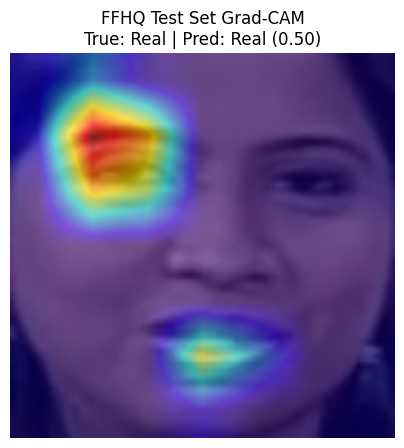

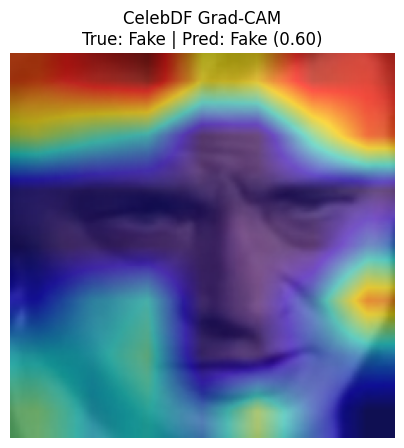

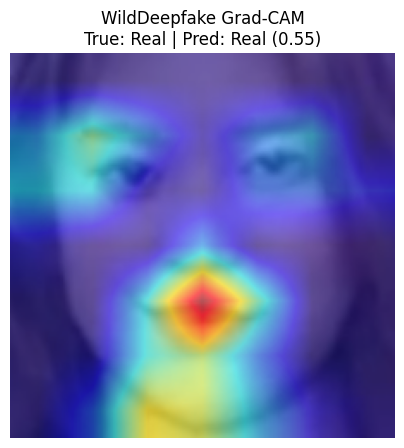

In [20]:
# Show Grad-CAM samples
show_gradcam(test_loader, "FFHQ Test Set")
show_gradcam(celebdf_loader, "CelebDF")
show_gradcam(wilddeepfake_loader, "WildDeepfake")

In [21]:
def show_batch_gradcam(loader, title="Batch Grad-CAM", image_weight=0.5):
    model.eval()
    all_images, all_labels = [], []

    # Collect up to 1000 samples
    for imgs, lbls in loader:
        all_images.extend(imgs)
        all_labels.extend(lbls)
        if len(all_images) >= 1000:
            break

    # Sample 4 fake + 4 real
    indices_fake = [i for i, l in enumerate(all_labels) if l == 1]
    indices_real = [i for i, l in enumerate(all_labels) if l == 0]

    num_fake = min(4, len(indices_fake))
    num_real = min(4, len(indices_real))
    chosen_indices = random.sample(indices_fake, num_fake) + random.sample(indices_real, num_real)
    random.shuffle(chosen_indices)

    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    for ax, idx in zip(axes.flatten(), chosen_indices):
        img = all_images[idx].unsqueeze(0).to(device)
        true_label = all_labels[idx].item()

        # Get prediction
        with torch.no_grad():
            output = model(img)
            probs = torch.softmax(output, dim=1)
            confidence, pred_label = torch.max(probs, 1)
            pred_label = pred_label.item()
            confidence = confidence.item()

        # Grad-CAM
        grayscale_cam = cam(input_tensor=img, targets=[ClassifierOutputTarget(pred_label)])[0]

        # De-normalize (ImageNet stats)
        img_np = img.squeeze().permute(1, 2, 0).cpu().numpy()
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_np = (img_np * std) + mean
        img_np = np.clip(img_np, 0, 1)

        # Overlay CAM
        vis = show_cam_on_image(img_np, grayscale_cam, use_rgb=True, image_weight=image_weight)

        ax.imshow(vis)
        ax.set_title(
            f"True: {'Fake' if true_label else 'Real'}\n"
            f"Pred: {'Fake' if pred_label else 'Real'} ({confidence:.2f})",
            fontsize=12
        )
        ax.axis("off")

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

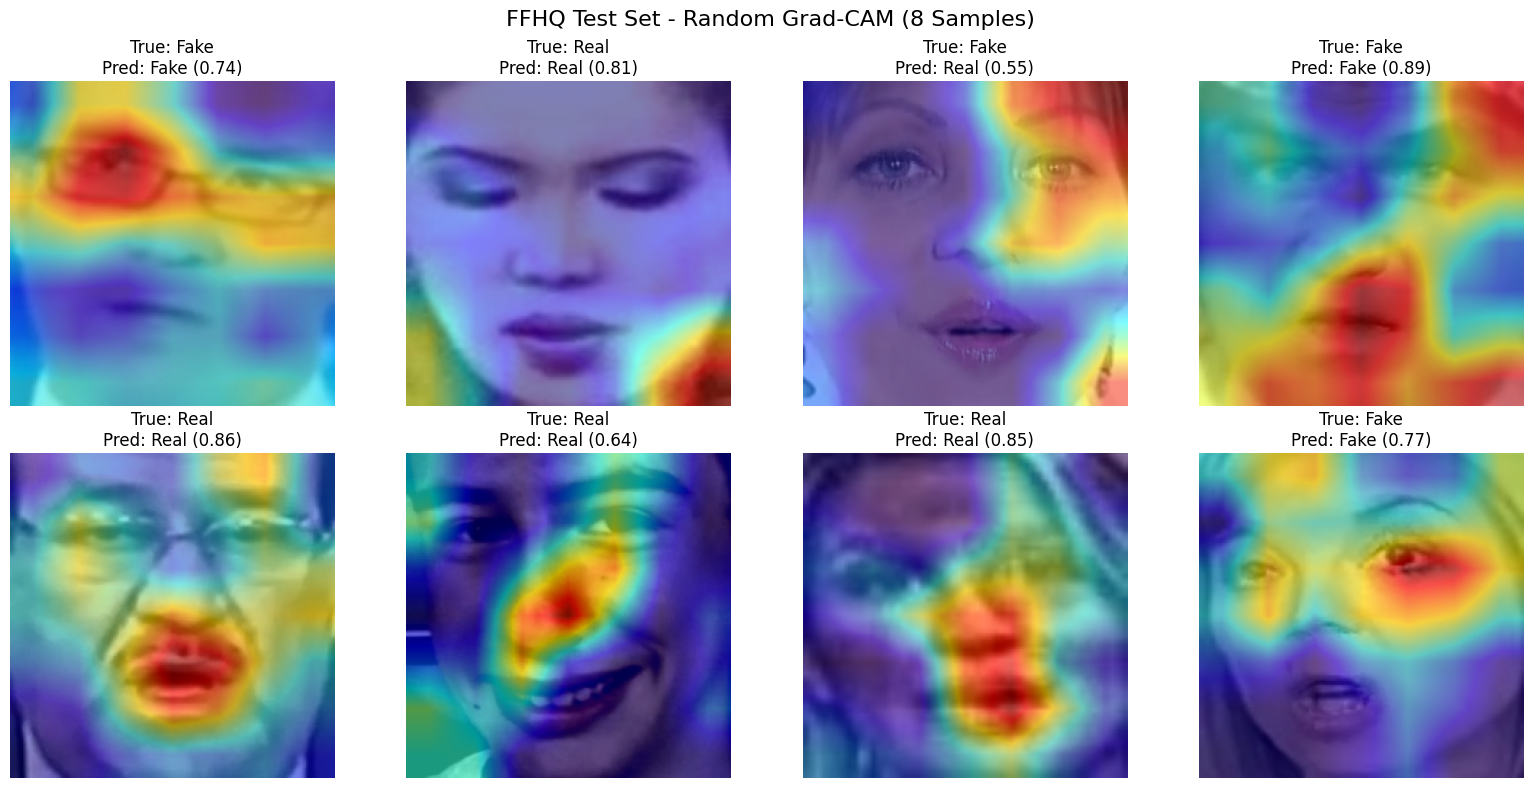

In [22]:
show_batch_gradcam(test_loader, title=" FFHQ Test Set - Random Grad-CAM (8 Samples)")

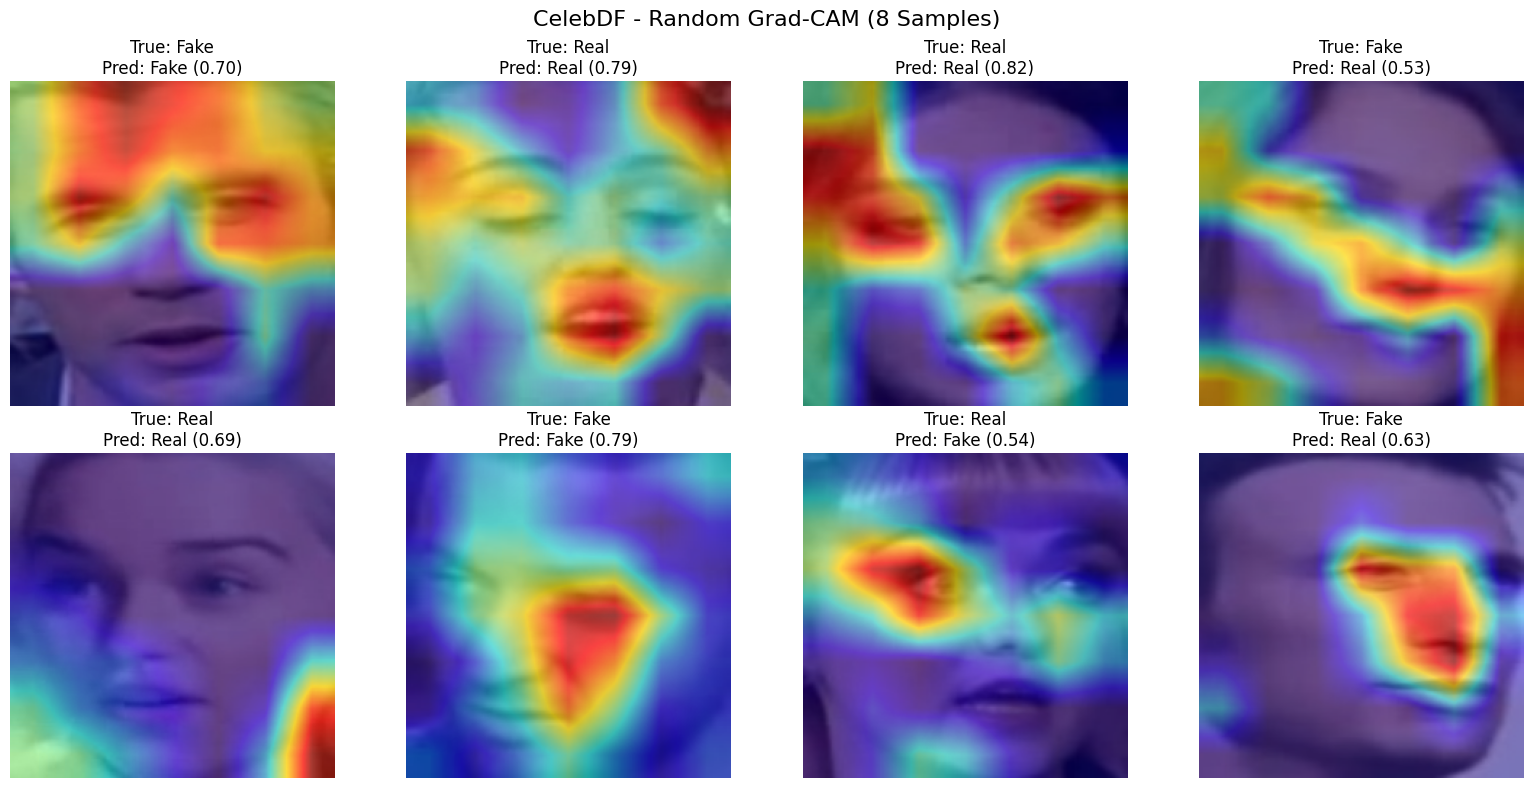

In [23]:
show_batch_gradcam(celebdf_loader, title="CelebDF - Random Grad-CAM (8 Samples)")

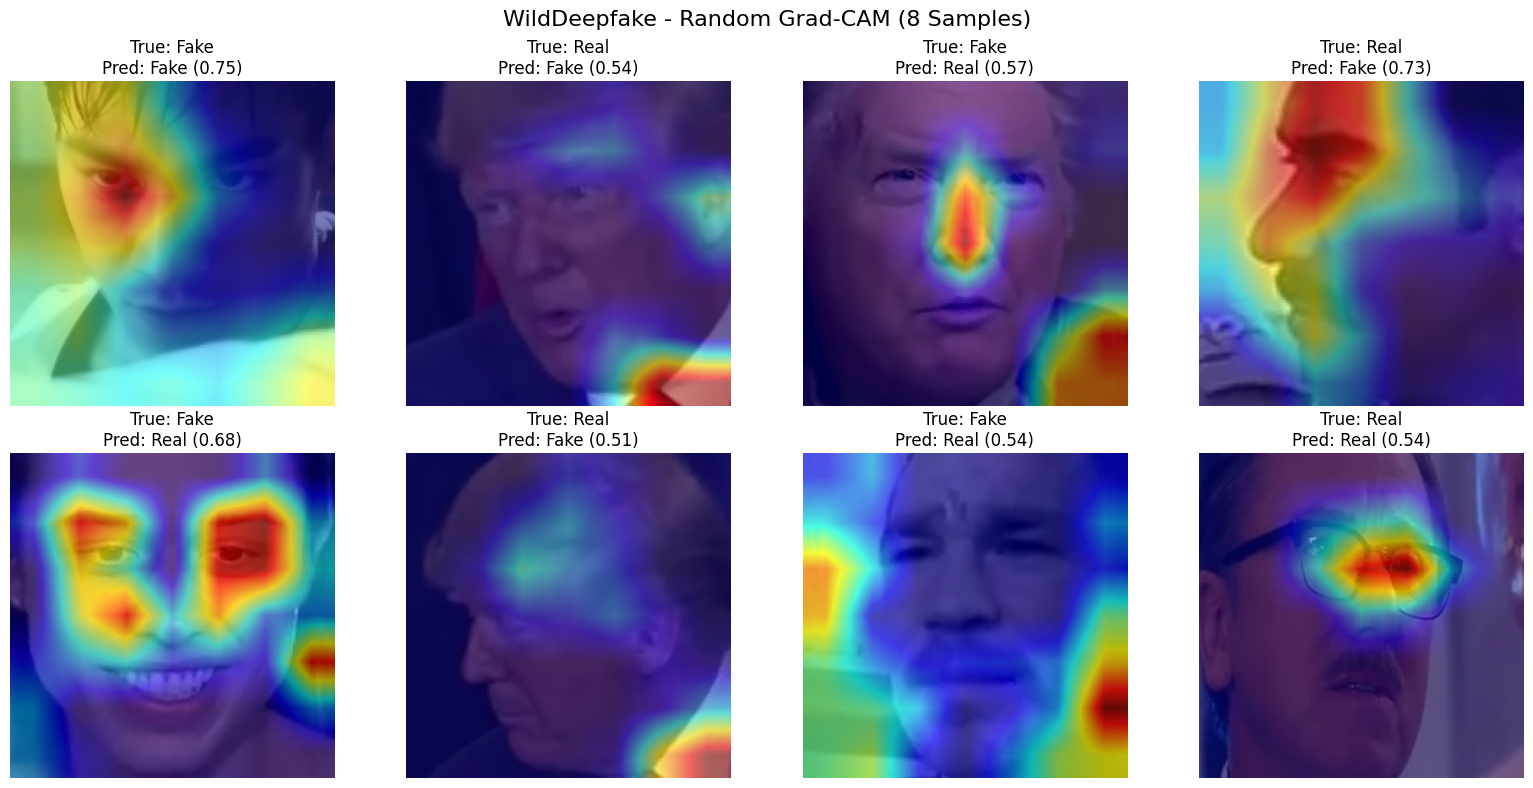

In [24]:
show_batch_gradcam(wilddeepfake_loader, title="WildDeepfake - Random Grad-CAM (8 Samples)")